In [1]:
import json
import sys
sys.path.append('../')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score

from utils.ltt_utils import create_x_y, run_ltt_cv, run_naive_precision_contorl

%load_ext autoreload
%autoreload 2

In [2]:
ANNOTATIONS_PATH = "/mnt/folcon/01_ovary_cuts/roi_annotation_united/all_annotations.json"
PREDICTIONS_PATH = "/home/vblot/follicle-assessment/data/04_model_predictions/yolo/results.json"
IOU_TH = .3
TARGET_PRECISION = 0.4
THS_DEPTH = np.arange(.3, .8, .05)
THS_OBJ = np.arange(.45, .8, .01)
DELTA = 0.001

In [3]:
len(THS_DEPTH), len(THS_OBJ)

(10, 35)

In [4]:
with open(ANNOTATIONS_PATH, "r") as f:
    annotations = json.load(f)

with open(PREDICTIONS_PATH, "r") as f:
    predictions = json.load(f)


In [12]:
ltt_results_depth = run_ltt_cv(annotations, predictions, target_precision=TARGET_PRECISION, iou_th=IOU_TH, ths_obj=THS_OBJ, ths_depth=THS_DEPTH, classes="all", with_depth=True, delta=DELTA, step_fst=35)

ltt_results_classical = run_ltt_cv(annotations, predictions, target_precision=TARGET_PRECISION, iou_th=IOU_TH, ths_obj=THS_OBJ, ths_depth=THS_DEPTH, classes="all", with_depth=False, delta=DELTA)

naive_method = run_naive_precision_contorl(annotations, predictions, target_precision=TARGET_PRECISION, iou_th=IOU_TH, ths_obj=THS_OBJ, classes="all")

  0%|          | 0/20 [00:00<?, ?it/s]/home/vblot/follicle-assessment/notebooks/../utils/metrics.py:149: RuntimeWarning: invalid value encountered in divide
  _true_positive(y_pred_th, y_repeat) /
/home/vblot/follicle-assessment/notebooks/../utils/metrics.py:149: RuntimeWarning: invalid value encountered in divide
  _true_positive(y_pred_th, y_repeat) /
/home/vblot/follicle-assessment/notebooks/../utils/metrics.py:149: RuntimeWarning: invalid value encountered in divide
  _true_positive(y_pred_th, y_repeat) /
/home/vblot/follicle-assessment/notebooks/../utils/metrics.py:149: RuntimeWarning: invalid value encountered in divide
  _true_positive(y_pred_th, y_repeat) /
/home/vblot/follicle-assessment/notebooks/../utils/metrics.py:149: RuntimeWarning: invalid value encountered in divide
  _true_positive(y_pred_th, y_repeat) /
/home/vblot/follicle-assessment/notebooks/../utils/metrics.py:149: RuntimeWarning: invalid value encountered in divide
  _true_positive(y_pred_th, y_repeat) /
/home/vb

In [6]:
def get_p_r_ltt(annotations, predictions, ltt_results, name):
    global_precisions = []
    global_recalls = []
    global_f1s = []
    for sld_name in ltt_results.keys():
        if len(ltt_results[sld_name]["best_th_depth"]) == 0:
            th_depth = 1
        else:
            th_depth = ltt_results[sld_name]["best_th_depth"][0]
        th_obj = ltt_results[sld_name]["best_th_obj"]
        X, y = create_x_y([sld_name], annotations, predictions, iou_th=IOU_TH, classes="all", with_depth=True)

        X[X[:, :, 1] > th_depth] = 0
        X = X[:, :, 0]
        X_th = X >= th_obj
        precisions = [precision_score(y[i], X_th[i], zero_division=1) for i in range(len(y))]
        recalls = [recall_score(y[i], X_th[i], zero_division=1) for i in range(len(y))]
        f1s = [f1_score(y[i], X_th[i]) for i in range(len(y))]

        global_precisions.append(np.mean(precisions))
        global_recalls.append(np.mean(recalls))
        global_f1s.append(np.mean(f1s))
    
    final_dico = {
        "Metric": ["precisions"] * len(global_precisions) + ["recalls"] * len(global_recalls) + ["f1s"] * len(global_f1s),
        "Value": global_precisions + global_recalls + global_f1s,
        "Method": [name] * (len(global_precisions) + len(global_recalls) + len(global_f1s))
    }

    return final_dico

In [7]:
dico_ltt_detph = get_p_r_ltt(annotations, predictions, ltt_results_depth, "LTT with depth")
dico_ltt_classical = get_p_r_ltt(annotations, predictions, ltt_results_classical, "LTT classical")
ltt_results_naive = get_p_r_ltt(annotations, predictions, naive_method, "Naive method")

In [8]:
concat_dico = pd.concat([pd.DataFrame(dico_ltt_detph), pd.DataFrame(dico_ltt_classical), pd.DataFrame(ltt_results_naive)])

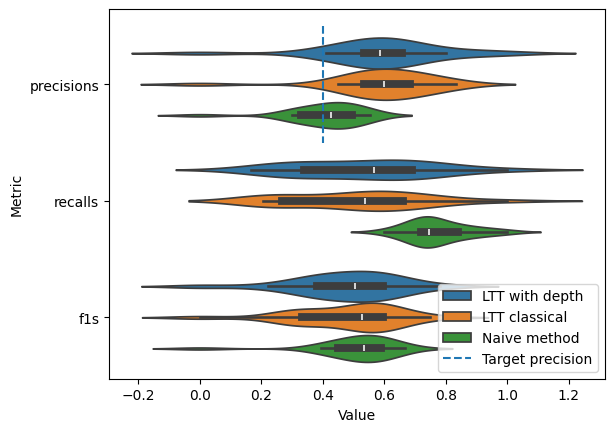

In [9]:
sns.violinplot(data=concat_dico,  x="Value", y="Metric", hue="Method", split=False, orient="h")
plt.vlines(TARGET_PRECISION, -0.5, .5, linestyles="dashed", label="Target precision")
plt.legend()


In [10]:
concat_dico[concat_dico["Metric"] == "precisions"].groupby("Method")["Value"].mean()

Method
LTT classical     0.591593
LTT with depth    0.590132
Naive method      0.407629
Name: Value, dtype: float64

In [11]:
concat_dico[concat_dico["Metric"] == "recalls"].groupby("Method")["Value"].mean()

Method
LTT classical     0.515219
LTT with depth    0.535938
Naive method      0.772972
Name: Value, dtype: float64